**SID**: 2246615 <br/>
**Name**: OTABEK DAVRONBEKOV

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns

In [45]:
import os

project_path = './'

os.listdir(project_path)

['.DS_Store',
 'dataset',
 'HAM10000_images_part_1',
 'dl_ham10000_project.ipynb',
 '.ipynb_checkpoints',
 'dataset-preprocess.ipynb',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv']

In [46]:
metadata = pd.read_csv(f'{project_path}/HAM10000_metadata.csv')
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [47]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [48]:
metadata.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [49]:
metadata['age'].isnull().value_counts()

age
False    9958
True       57
Name: count, dtype: int64

In [50]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64

In [51]:
metadata['age'].fillna((metadata['age'].mean()), inplace=True)

<AxesSubplot: xlabel='age', ylabel='count'>

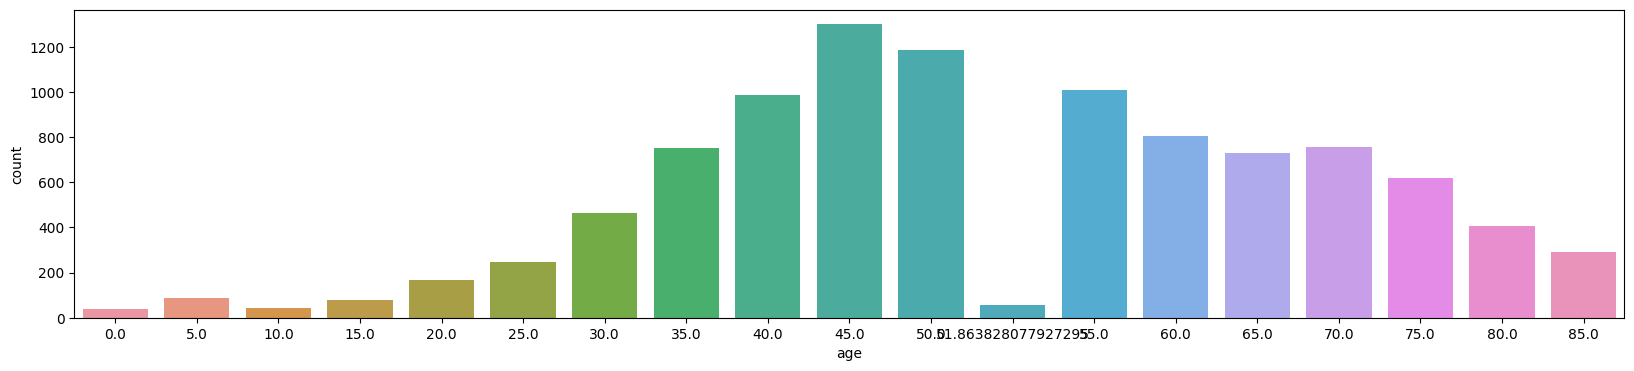

In [52]:
plt.subplots(figsize=(20, 4))
sns.countplot(x='age', data=metadata)

In [53]:
metadata['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

<AxesSubplot: xlabel='sex', ylabel='count'>

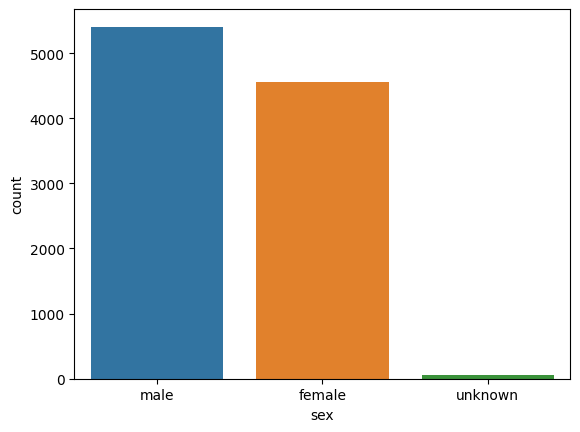

In [54]:
sns.countplot(x='sex', data=metadata)

In [55]:
metadata['localization'].value_counts()

localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64

<AxesSubplot: xlabel='localization', ylabel='count'>

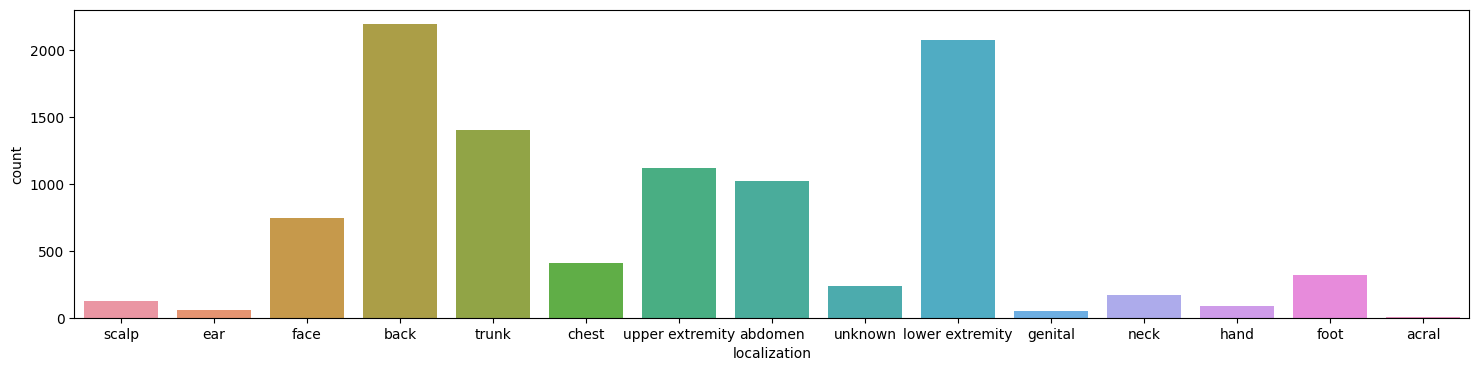

In [56]:
plt.subplots(figsize=(18,4))
sns.countplot(x='localization', data=metadata)

In [57]:
metadata['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

<AxesSubplot: xlabel='dx', ylabel='count'>

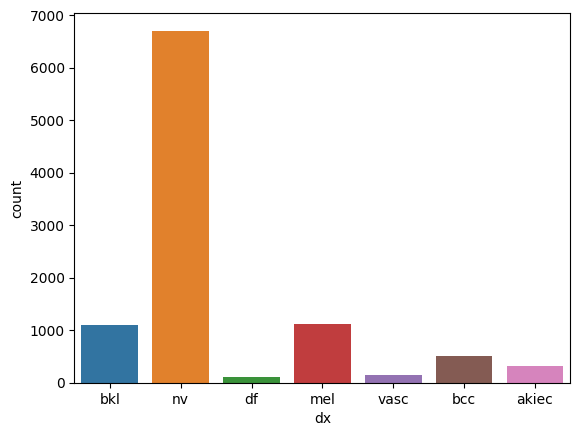

In [58]:
sns.countplot(x='dx', data=metadata)

In [59]:
classes = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

inv_classes = {}
for k, v in classes.items():
    inv_classes[v] = k

print('***CLASSES***')
print(classes)

print('***INV CLASSES***')
print(inv_classes)

***CLASSES***
{0: 'nv', 1: 'mel', 2: 'bkl', 3: 'bcc', 4: 'akiec', 5: 'vasc', 6: 'df'}
***INV CLASSES***
{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}


In [60]:
metadata['dx_int'] = metadata['dx'].replace(inv_classes)
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_int
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2


In [61]:
metadata['dx_type'].value_counts()

dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

<AxesSubplot: xlabel='dx_type', ylabel='count'>

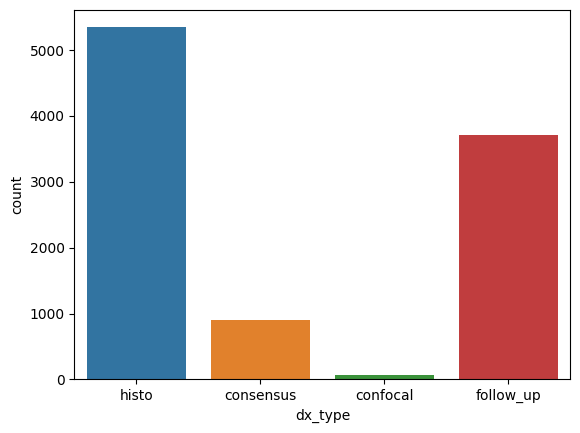

In [62]:
sns.countplot(x='dx_type', data=metadata)

SPLITTING DATASET AND DEFINING LABELS

In [63]:
batch_size = 32
img_height = 450
img_width = 600

In [64]:
data_dir = f'{project_path}dataset/'
os.listdir(data_dir)

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

#### getting 80% of dataset for training

In [65]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.


#### getting 20% of dataset for validation

In [66]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [67]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


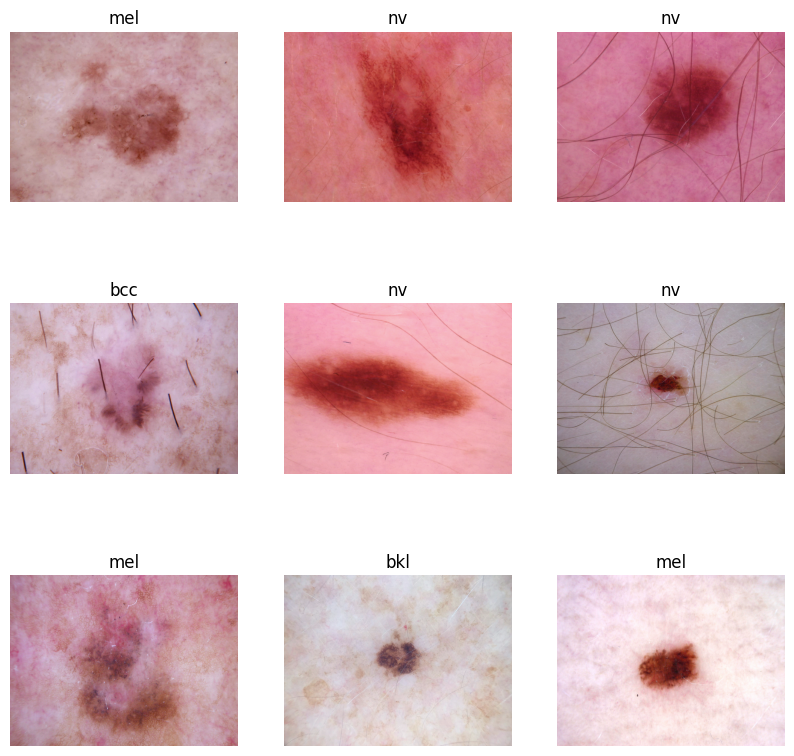

In [68]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [69]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 450, 600, 3)
(32,)


In [72]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [73]:
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 450, 600, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 448, 598, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 224, 299, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 297, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 148, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 146, 32)     

In [74]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
from keras.callbacks import EarlyStopping

early_callback = EarlyStopping(monitor='loss', patience=3)

In [76]:
history = model.fit(train_ds, validation_data=val_ds, callbacks=[early_callback], epochs=30)

Epoch 1/30


2023-05-01 20:13:38.982347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 4.1952 - accuracy: 0.6664

2023-05-01 20:15:17.509496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 108s 427ms/step - loss: 4.1952 - accuracy: 0.6664 - val_loss: 4.1545 - val_accuracy: 0.6720
Epoch 2/30
251/251 [==============================] - 107s 424ms/step - loss: 4.2249 - accuracy: 0.6689 - val_loss: 4.1545 - val_accuracy: 0.6720
Epoch 3/30
251/251 [==============================] - 107s 427ms/step - loss: 4.2249 - accuracy: 0.6689 - val_loss: 4.1545 - val_accuracy: 0.6720
Epoch 4/30
251/251 [==============================] - 107s 426ms/step - loss: 4.2249 - accuracy: 0.6689 - val_loss: 4.1545 - val_accuracy: 0.6720


In [78]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

63/63 - 9s - loss: 4.1545 - accuracy: 0.6720 - 9s/epoch - 143ms/step
